In [1]:
# Carregando as bibliotecas

import pandas as pd
import numpy as np

import yfinance
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import kaleido

import plotly.figure_factory as ff
from scipy.stats import shapiro
from scipy.stats import norm

import warnings

warnings.filterwarnings("ignore")

import os
cwd = os.getcwd()

In [2]:
tickers = ["PETR4.SA", "VALE", "ITUB4.SA"
           , "CMIG4.SA", "USIM5.SA", "CSNA3.SA"]

start = "2020-01-02"
end = "2022-12-31"

df0 = yfinance.download(tickers, start, end)["Adj Close"]
df0 = df0.dropna(axis = 0) 

retornos = df0.pct_change()

# Vamos selecionar uma carteira com pesos aleatórios para cada ativo

pesos = np.random.dirichlet(np.ones(6), size = 1)

retornos_portfolio = retornos.mul(pesos, axis = 1)

retornos["Portfolio"] = retornos_portfolio.sum(axis = 1)
retornos["Portfolio"] = retornos["Portfolio"]*100
retornos.dropna(inplace = True)


cov_retornos = retornos.iloc[:, 0:6].cov()
media_retornos = retornos.iloc[:, 0:6].mean()


# Calculando a média dos retornos ponderados e a média da carteira

media_portfolio = media_retornos@pesos.T
sd_portfolio = np.sqrt(pesos@cov_retornos@pesos.T)

ci5 = 0.05
ci1 = 0.01
var5_cov = np.round(norm.ppf(ci5, media_portfolio, sd_portfolio), 4)*100
var1_cov = np.round(norm.ppf(ci1, media_portfolio, sd_portfolio), 4)*100

n = 5 #número de dias
var5_cov_n = np.round(var5_cov*np.sqrt(n), 2)
var1_cov_n = np.round(var1_cov*np.sqrt(n), 2)


print("VaR pelo método da covariância")
print("--------------------------")
print("Existe 5% de chances do portfolio perder mais de " + str(var5_cov[0][0]) + "% em 1 dia")
print("Existe 1% de chances do portfolio perder mais de " + str(var1_cov[0][0]) + "% em 1 dia")
print("")
print("Existe 5% de chances do portfolio perder mais de " + str(var5_cov_n[0][0]) + "% em " + str(n) + " dias")
print("Existe 1% de chances do portfolio perder mais de " + str(var1_cov_n[0][0]) + "% em " + str(n) + " dias")

[*********************100%***********************]  6 of 6 completed
VaR pelo método da covariância
--------------------------
Existe 5% de chances do portfolio perder mais de -4.53% em 1 dia
Existe 1% de chances do portfolio perder mais de -6.45% em 1 dia

Existe 5% de chances do portfolio perder mais de -10.13% em 5 dias
Existe 1% de chances do portfolio perder mais de -14.42% em 5 dias


# O CVaR

O CVaR é o que muitos consideram uma melhoria do VaR, pois leva em consideração o formato da distribuição dos retornos. Também é conhecido como Expected Shortfall (ES), pois é uma expectativa sobre todas as diferentes perdas possíveis maiores que o VaR e suas correspondentes probabilidades estimadas.

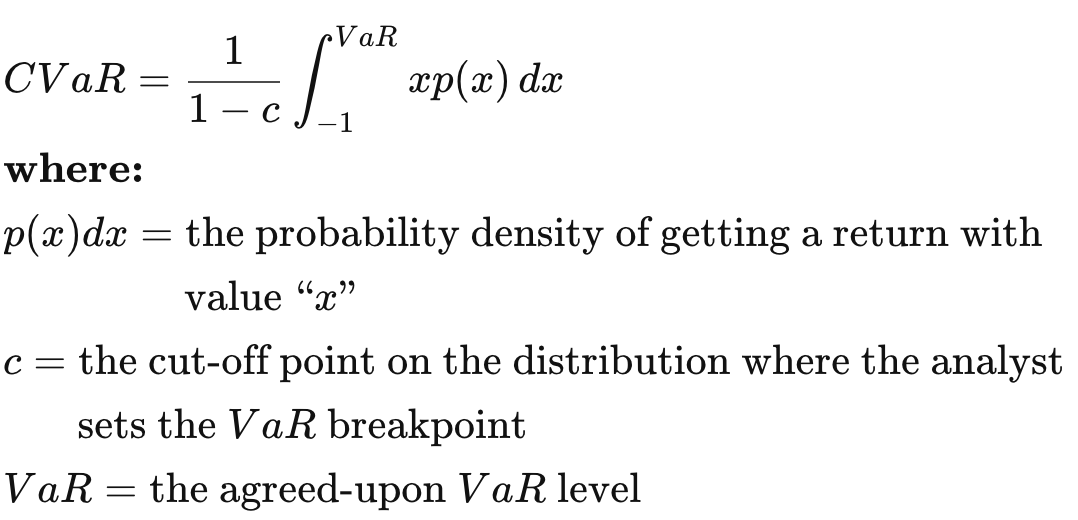

In [3]:
var5_cov[0][0]

-4.53

In [4]:
cvar5 = np.round(np.mean(retornos[retornos["Portfolio"] < var5_cov[0][0]]["Portfolio"]), 2)
cvar1 = np.round(np.mean(retornos[retornos["Portfolio"] < var1_cov[0][0]]["Portfolio"]), 2)

cvar5_n = np.round(np.mean(retornos[retornos["Portfolio"] < var5_cov_n[0][0]]["Portfolio"]), 2)
cvar1_n = np.round(np.mean(retornos[retornos["Portfolio"] < var1_cov_n[0][0]]["Portfolio"]), 2)

In [5]:
print("Pelo CVaR")
print("--------------------------")
print("Existe 5% de chances do portfolio perder mais de " + str(cvar5) + "% em 1 dia")
print("Existe 1% de chances do portfolio perder mais de " + str(cvar1) + "% em 1 dia")
print("")
print("Existe 5% de chances do portfolio perder mais de " + str(cvar1_n) + "% em " + str(n) + " dias")
print("Existe 1% de chances do portfolio perder mais de " + str(cvar5_n) + "% em " + str(n) + " dias")

Pelo CVaR
--------------------------
Existe 5% de chances do portfolio perder mais de -7.5% em 1 dia
Existe 1% de chances do portfolio perder mais de -10.78% em 1 dia

Existe 5% de chances do portfolio perder mais de -18.73% em 5 dias
Existe 1% de chances do portfolio perder mais de -14.07% em 5 dias


- O CVaR é maior porque está capturando mais informações sobre a forma da distribuição, também conhecida como os momentos da distribuição.
- Se as caudas tiverem mais massa, ele captura isso. Em geral, é considerada uma métrica muito superior em comparação com o VaR e você deve usá-la sobre o VaR na maioria dos casos.